<a href="https://colab.research.google.com/github/exterm/uvm-pocs/blob/main/pocs6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#imports

In [ ]:
#plotting
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns 

import pandas as pd # library for data analysis
import numpy as np
import scipy.stats as stats
import scipy

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t

## Initialize Filesystem

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

# create directory for this assignment
try: 
    os.mkdir('/content/drive/MyDrive/pocs/06/') 
except OSError as error: 
    print(error)

Mounted at /content/drive
[Errno 17] File exists: '/content/drive/MyDrive/pocs/06/'


# Fetch Data

In [ ]:

filepath_ulysses = 'https://pdodds.w3.uvm.edu/teaching/courses/2022-2023pocsverse/docs/ulysses.txt'

pride_txt = pd.read_fwf('/content/drive/MyDrive/pocs/06/pg42671.txt')
monte_txt = pd.read_fwf('/content/drive/MyDrive/pocs/06/17989-0.txt')
ulysses = pd.read_csv(filepath_ulysses, header=None, sep=':', names=['word', 'word_frequency'])

# Q2 Code up Simon’s rich-gets-richer model.
Show Zipf distributions for ρ = 0.10, 0.01, and 0.001. and perform regressions to
test α = 1 − ρ.
Run the simulation for long enough to produce decent scaling laws (recall: three
orders of magnitude is good).
Averaging over simulations will produce cleaner results so try 10 and then, if
possible, 100.
Note the first mover advantage.

In [ ]:
from collections import Counter
from random import random
import numpy as np
import scipy.stats as st

Step 1: Code Simon's Rich Get Richer Model 

In [ ]:
import random as r
from collections import defaultdict

def run_simon_run(steps, rho):
  individuals = [[1,0]]
  num_types = 1

  for t in range(steps-1):
    rand = r.uniform(0, 1)
    if rand < rho:
      # mutation
      individuals.append([t, num_types])
      num_types = num_types + 1
    else:
      # replication
      individuals.append([t, r.choice(individuals)[1]])

  groups = defaultdict(int)

  for i, t in individuals:
    groups[t] += 1

  return pd.DataFrame.from_dict(groups, columns=['Size'], orient='index')

In [ ]:
def rank_distribution(dataframe):
  new_dataframe = dataframe.copy()
  new_dataframe['Rank'] = st.rankdata(-dataframe['Size'])
  return new_dataframe

def rank_distributions(distributions):
  return [rank_distribution(dist) for dist in distributions]

In [ ]:
# log-log regression
def regress_ll(x, y):
  result = stats.linregress(np.log10(x), np.log10(y))
  # print(f"R squared: {result.rvalue**2}")
  return result

def regress_zipf(dataframe):
  return regress_ll(dataframe['Rank'], dataframe['Size'])

Step 2. Show Zipfs Distribution for ρ = 0.10, 0.01, and 0.001 and perform regressions to test α = 1 − ρ.

In [ ]:
TARGET_GROUP_COUNT = 1_000
NUM_SIMULATIONS = 100

def alpha_for_rho(rho):
  n = int(TARGET_GROUP_COUNT/rho)
  distributions = [run_simon_run(n, rho) for i in range(NUM_SIMULATIONS)]

  print(f"Rho: {rho}, number of individuals: {n}, number of simulations: {len(distributions)}")
  print(f"Average number of groups: {np.mean(list(map(lambda d: len(d), distributions)))}")

  regressions = list(map(regress_zipf, rank_distributions(distributions)))
  slopes = [r.slope for r in regressions]
  print(f"Average R squared: {np.mean([r.rvalue**2 for r in regressions])}")
  return -np.mean(slopes)

rhos = [0.1, 0.01, 0.001]

for rho in rhos:
  expected_alpha = 1 - rho
  alpha = alpha_for_rho(rho)
  print(f"Measured alpha: {alpha}, expected alpha: {expected_alpha}")
  print()

Rho: 0.1, number of individuals: 10000, number of simulations: 100
Average number of groups: 997.73
Average R squared: 0.9942216073740283
Measured alpha: 1.0362070378428847, expected alpha: 0.9



KeyboardInterrupt: ignored

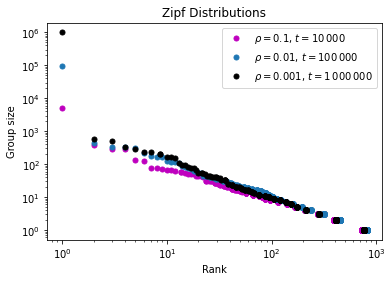

In [103]:
x1 = run_simon_run(10000, 0.1)
y1 = rank_distribution(x1)

x2 =run_simon_run(100000, 0.01)
y2 = rank_distribution(x2)

x3 = run_simon_run(1000000, 0.001)
y3 = rank_distribution(x3)

plt.plot(y1['Rank'], y1['Size'],'m-', marker="o", markersize=5, linewidth=0, label=r'$\rho = 0.1$, $t=10\,000$')
plt.plot(y2['Rank'], y2['Size'],'o--',marker="o", markersize=5, linewidth=0, label=r'$\rho = 0.01$, $t=100\,000$')
plt.plot(y3['Rank'], y3['Size'],'k-',marker="o", markersize=5, linewidth=0, label=r'$\rho = 0.001$, $t=1\,000\,000$')

plt.legend()
plt.xlabel('Rank')
plt.ylabel('Group size')
plt.title("Zipf Distributions")
plt.loglog(base=10)
plt.savefig('/content/drive/MyDrive/pocs/06/02-zipf.png', dpi=600)
plt.show()

# Q4

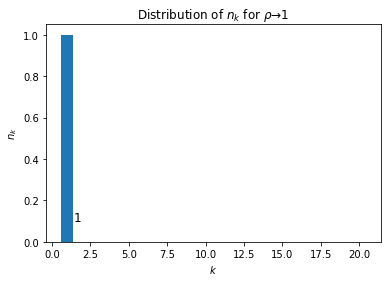

In [ ]:
t = 20
xs = np.arange(1, t+1)
ys = np.zeros(t)
ys[0] = 1
plt.bar(xs, ys)
plt.annotate('$1$', (1, 0), fontsize=12, xytext=(1+2/100*t, 10/100))
plt.xlabel("$k$")
plt.ylabel("$n_k$")
plt.title("Distribution of $n_k$ for $\\rho\\to1$")
plt.savefig('/content/drive/MyDrive/pocs/06/04-rho-1.png', dpi=600)
plt.show()

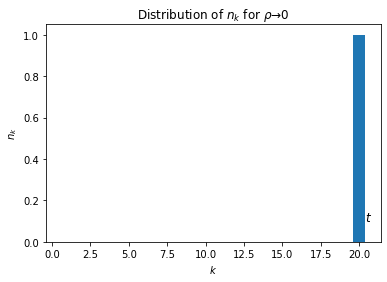

In [ ]:
t = 20
xs = np.arange(1, t+1)
ys = np.zeros(t)
ys[t-1] = 1
plt.bar(xs, ys)
plt.annotate('$t$', (t, 0), fontsize=12, xytext=(t+2/100*t, 10/100))
plt.xlabel("$k$")
plt.ylabel("$n_k$")
plt.title("Distribution of $n_k$ for $\\rho\\to0$")
plt.savefig('/content/drive/MyDrive/pocs/06/04-rho-0.png', dpi=600)
plt.show()

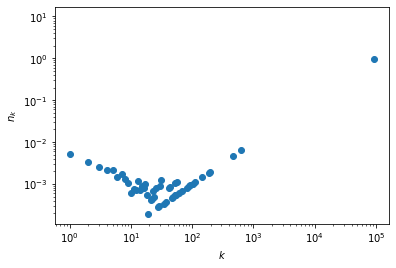

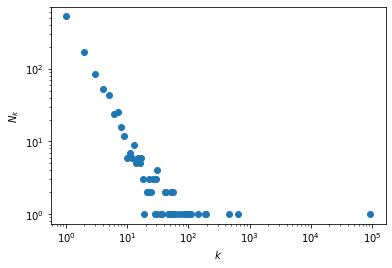

,k,Nk,nk
45,1,524,0.00524
23,2,171,0.00342
42,3,85,0.00255
35,4,53,0.00212
3,5,43,0.00215
44,6,24,0.00144
28,7,25,0.00175
30,8,16,0.00128
48,9,12,0.00108
36,10,6,0.00060


In [ ]:
t = 100_000
group_sizes = run_simon_run(t, 0.01)

Nk = defaultdict(int)

for size in group_sizes['Size']:
  Nk[size] += 1

df = pd.DataFrame(list(Nk.items()), columns=['k', 'Nk'])
df['nk'] = df['k']*df['Nk'] / t

df = df.sort_values(by=['k'])

plt.scatter(df['k'], df['nk'])
plt.loglog(10)
# plt.annotate('$t$', (t, 0), fontsize=12, xytext=(t+2/100*t, 10/100))
plt.xlabel("$k$")
plt.ylabel("$n_k$")
# plt.title("Distribution of $n_k$ for $\\rho\\to0$")
# plt.savefig('/content/drive/MyDrive/pocs/06/04-rho-0.png', dpi=600)
plt.show()

plt.scatter(df['k'], df['Nk'])
plt.loglog(10)
# plt.annotate('$t$', (t, 0), fontsize=12, xytext=(t+2/100*t, 10/100))
plt.xlabel("$k$")
plt.ylabel("$N_k$")
plt.show()

df

# Q5 (6 + 3 + 3 points)
In Simon’s original model, the expected total number of distinct groups at time t
is ρt. Recall that each group is made up of elements of a particular flavor.
In class, we derived the fraction of groups containing only 1 element, finding
n
(g)
1 =
N1(t)
ρt
=
1
2 − ρ

Colon-separated text file (first column = word, second column = word
frequency f):
https://pdodds.w3.uvm.edu/teaching/courses/2022-
2023pocsverse/docs/ulysses.txt Note that some matching words with differing capitalization are recorded as
separate words.

In [ ]:
ulysses

(b) Using data for James Joyce’s Ulysses (see below), first show that Simon’s
estimate for the innovation rate ρest ≃ 0.115 is reasonably accurate for the
version of the text’s word counts given below.
Hint: You should find a slightly higher number than Simon did.  Hint: Do not compute ρest from an estimate of γ.

In [ ]:
innov_rate_ulysses = len(ulysses['word_frequency'])/(ulysses['word_frequency'].sum())
innov_rate_ulysses

c. Now compare the theoretical estimates for n
(g)
1
, n
(g)
2
, and n
(g)
3
, with empirical
values you obtain for Ulysses.

In [ ]:
word_counts_bow_ulysses_1 =  ulysses[ulysses['word_frequency'] == 1] 
word_counts_bow_ulysses_2 = ulysses[ulysses['word_frequency'] == 2] 
word_counts_bow_ulysses_3 = ulysses[ulysses['word_frequency'] == 3]

In [ ]:
frac_words_once_ulysses = len(word_counts_bow_ulysses_1.index)/len(ulysses.index)
frac_words_once_ulysses

In [ ]:
frac_words_twice_ulysses = len(word_counts_bow_ulysses_2.index)/len(ulysses.index)
frac_words_twice_ulysses

In [ ]:
frac_words_thrice_ulysses = len(word_counts_bow_ulysses_3.index)/len(ulysses.index)
frac_words_thrice_ulysses

In [ ]:
#put our value of rho into the theoretical estimates 

# Q6 (3 + 3)
Repeat the preceding data analysis for Ulysses for Jane Austen’s “Pride and
Prejudice” and Alexandre Dumas’ “Le comte de Monte-Cristo” (in the original
French), working this time from the original texts.
For each text, measure the fraction of words that appear only once, twice, and
three times, and compare them with the theoretical values offered by Simon’s
model.

Download text (UTF-8) versions from https://www.gutenberg.org :
• Pride and Prejudice: https://www.gutenberg.org/ebooks/42671 .
• Le comte de Monte-Cristo: https://www.gutenberg.org/ebooks/17989 

You will need to parse and count words using your favorite/most-hated language
(Python, R, Perl-ha-ha, etc.).
Gutenberg adds some (non-uniform) boilerplate to the beginning and ends of texts,
and you should remove that first. Easiest to do so by inspection for just two texts.
For a curated version of Gutenberg, see this paper by Gerlach and Font-Clos:
https://arxiv.org/abs/1812.08092 

In [ ]:
import sklearn as sk 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.probability import DictionaryProbDist

In [ ]:
pride_txt

In [ ]:
monte_txt

##monte cristo

In [ ]:
#lowercase everything
monte_txt['LE COMTE DE MONTE-CRISTO'].astype(str).str.lower()

In [ ]:
#create a bag of words monte
list_of_texts_monte = monte_txt['LE COMTE DE MONTE-CRISTO'].tolist()


In [ ]:
#Setup scikit vectorizer

vectorizer_monte = CountVectorizer(min_df=1)
term_doc_matrix_monte = vectorizer_monte.fit_transform(list_of_texts_monte)
vectorizer_monte.get_feature_names_out()

In [ ]:
nltk.download('punkt')

In [ ]:
# Put BoW vectors into a new df
monte_texts_bow = pd.DataFrame(term_doc_matrix_monte.toarray(), columns=vectorizer_monte.get_feature_names_out())

#getting the counts of words in our bag of words
word_counts_bow_monte = monte_texts_bow.sum(axis=0).sort_values(ascending=True)

#Counts Calculates the counts that each word appears in a document out of all the words in the document.
all_words_monte = ' '.join([word for word in list_of_texts_monte])
words_monte = nltk.word_tokenize(all_words_monte)
fd_monte = FreqDist(words_monte)
fd_monte.most_common()
fd_monte.tabulate()

#confirming how many unique words we have
list_set_monte = set(words_monte)
unique_list_monte = (list(list_set_monte))
uniqueWordCount_monte = len(set(unique_list_monte))
uniqueWordCount_monte


In [ ]:
word_counts_bow_monte.plot()

In [ ]:
#For each text, measure the fraction of words that appear only once, twice, and three times

In [ ]:
word_counts_bow_monte = word_counts_bow_monte.to_frame(name=None)

In [ ]:
word_counts_bow_monte_1 = word_counts_bow_monte[word_counts_bow_monte[0] == 1] 
word_counts_bow_monte_2 = word_counts_bow_monte[word_counts_bow_monte[0] == 2] 
word_counts_bow_monte_3 = word_counts_bow_monte[word_counts_bow_monte[0] == 3] 

In [ ]:
innov_rate_monte = len(word_counts_bow_monte)/(word_counts_bow_monte.sum())
innov_rate_monte

In [ ]:
#put our value of rho into the theoretical estimates 

In [ ]:
frac_words_once_monte = len(word_counts_bow_monte_1.index)/len(word_counts_bow_monte.index)
frac_words_once_monte

In [ ]:
frac_words_twice_monte = len(word_counts_bow_monte_2.index)/len(word_counts_bow_monte.index)
frac_words_twice_monte

In [ ]:
frac_words_trice_monte = len(word_counts_bow_monte_3.index)/len(word_counts_bow_monte.index)
frac_words_trice_monte

##PRIDE & PREJUDICE

In [ ]:
#lower case everything 
pride_txt['PRIDE & PREJUDICE.'].astype(str).str.lower()

In [ ]:
#create a bag of words pride
list_of_texts_pride = pride_txt['PRIDE & PREJUDICE.'].tolist()

In [ ]:
#Setup scikit vectorizer

vectorizer_pride = CountVectorizer(min_df=1)
term_doc_matrix_pride = vectorizer_pride.fit_transform(list_of_texts_pride)
vectorizer_pride.get_feature_names_out()

In [ ]:
# Put BoW vectors into a new df
pride_texts_bow = pd.DataFrame(term_doc_matrix_pride.toarray(), columns=vectorizer_pride.get_feature_names_out())

#getting the counts of words in our bag of words
word_counts_bow_pride = pride_texts_bow.sum(axis=0).sort_values(ascending=True)

#Counts Calculates the counts that each word appears in a document out of all the words in the document.
all_words_pride = ' '.join([word for word in pride_texts_bow])
words_pride = nltk.word_tokenize(all_words_pride)
fd_pride = FreqDist(words_pride)
fd_pride.most_common()
fd_pride.tabulate()

#confirming how many unique words we have
list_set_pride = set(words_pride)
unique_list_pride = (list(list_set_pride))
uniqueWordCount_pride = len(set(unique_list_pride))
uniqueWordCount_pride

In [ ]:
word_counts_bow_pride.plot()

In [ ]:
#For each text, measure the fraction of words that appear only once, twice, and three times

In [ ]:
word_counts_bow_pride = word_counts_bow_pride.to_frame(name=None)

In [ ]:
word_counts_bow_pride_1 = word_counts_bow_pride[word_counts_bow_pride[0] == 1] 
word_counts_bow_pride_2 = word_counts_bow_pride[word_counts_bow_pride[0] == 2] 
word_counts_bow_pride_3 = word_counts_bow_pride[word_counts_bow_pride[0] == 3] 

In [ ]:
innov_rate_pride = len(word_counts_bow_pride.index)/(word_counts_bow_pride.sum())
innov_rate_pride

In [ ]:
#put our value of rho into the theoretical estimates 

In [ ]:
frac_words_once_pride = len(word_counts_bow_pride_1.index)/len(word_counts_bow_pride.index)
frac_words_once_pride

In [ ]:
frac_words_twice_pride = len(word_counts_bow_pride_2.index)/len(word_counts_bow_pride.index)
frac_words_twice_pride

In [ ]:
frac_words_trice_pride = len(word_counts_bow_pride_3.index)/len(word_counts_bow_pride.index)
frac_words_trice_pride